# Experimentos: Baseline com QSVM+ PCA

Este notebook estabelece baselines de performance com QSVM no dataset Student Performance

Usando PCA


In [2]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC


from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Carregando o dataset localmente
path = '../data/student-mat.csv'
df_completo = pd.read_csv(path, sep=';')

# Separando features e alvos originais
y = df_completo[['G1', 'G2', 'G3']]
X = df_completo.drop(columns=['G1', 'G2', 'G3'])

print("Dataset carregado!")

Dataset carregado!


In [3]:
X.head(5) 

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,4
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,2
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,4


In [4]:
# Dimensões dos dados do Student Performance Dataset
print("\nDimensões do Student Performance Dataset:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")



Dimensões do Student Performance Dataset:
X: (395, 30)
y: (395, 3)


In [5]:
# Data cleaning
# check for missing values
print("\nVerificando valores ausentes:")
print(X.isnull().sum())


Verificando valores ausentes:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
dtype: int64


## Pré-processamento dataset Student Performance

In [6]:
# Criando o alvo de classificação binário
y_final = np.where(y['G3'] >= 10, 1, 0)

# Aplicando One-Hot Encoding
X_final = pd.get_dummies(X, drop_first=True)

print("--- Pré-processamento inicial concluído ---")
print("Formato das features (X_final):", X_final.shape)
print("Distribuição das classes (Aprovado/Reprovado):")
print(pd.Series(y_final).value_counts())

--- Pré-processamento inicial concluído ---
Formato das features (X_final): (395, 39)
Distribuição das classes (Aprovado/Reprovado):
1    265
0    130
Name: count, dtype: int64


##  Divisão, Normalização e Análise do PCA

Dados originais divididos e normalizados.


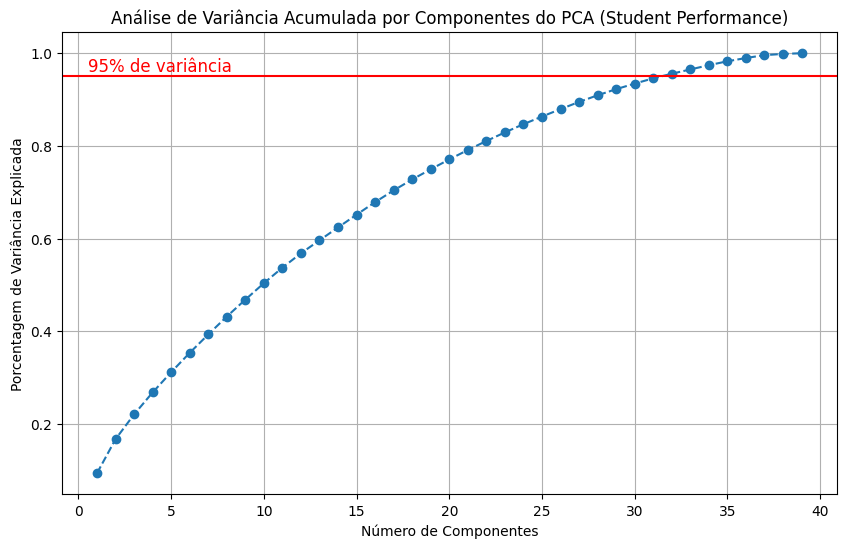

In [7]:
# Divisão e Normalização (usando o dataset completo)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.25, random_state=42, stratify=y_final
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)
print("Dados originais divididos e normalizados.")

# Análise de Variância do PCA 
pca_analise = PCA()
pca_analise.fit(X_train_scaled)
variancia_acumulada = np.cumsum(pca_analise.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.title('Análise de Variância Acumulada por Componentes do PCA (Student Performance)')
plt.xlabel('Número de Componentes')
plt.ylabel('Porcentagem de Variância Explicada')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.96, '95% de variância', color = 'red', fontsize=12)
plt.show()

In [8]:

N_COMPONENTES = 5
pca = PCA(n_components=N_COMPONENTES)

print(f"PCA aplicado para reduzir para {N_COMPONENTES} componentes.")
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# SMOTE (nos dados já reduzidos)
smote = SMOTE(random_state=42)
X_train_resampled_pca, y_train_resampled = smote.fit_resample(X_train_pca, y_train)
print("SMOTE aplicado ao conjunto de treino reduzido com PCA.")

# training
num_features_pca = X_train_resampled_pca.shape[1]
feature_map_sp_pca = ZZFeatureMap(feature_dimension=num_features_pca, reps=1)
fidelity_kernel_sp_pca = FidelityQuantumKernel(feature_map=feature_map_sp_pca)
qsvc_sp_pca = QSVC(quantum_kernel=fidelity_kernel_sp_pca, random_state=42)

print(f"\nModelo QSVM criado para {num_features_pca} features. Iniciando treinamento...")

start_time = time.time()
qsvc_sp_pca.fit(X_train_resampled_pca, y_train_resampled)
end_time = time.time()
print(f"Modelo treinado em {end_time - start_time:.2f} segundos.")

qsvc_predictions_pca = qsvc_sp_pca.predict(X_test_pca)

print("\n Relatório de Classificação para o QSVM com PCA (Student Performance(port)) ")
print(classification_report(y_test, qsvc_predictions_pca, target_names=['Reprovado', 'Aprovado']))

PCA aplicado para reduzir para 5 componentes.
SMOTE aplicado ao conjunto de treino reduzido com PCA.

Modelo QSVM criado para 5 features. Iniciando treinamento...
Modelo treinado em 347.44 segundos.

 Relatório de Classificação para o QSVM com PCA (Student Performance(port)) 
              precision    recall  f1-score   support

   Reprovado       0.39      0.42      0.41        33
    Aprovado       0.70      0.67      0.68        66

    accuracy                           0.59        99
   macro avg       0.54      0.55      0.54        99
weighted avg       0.60      0.59      0.59        99

